In [7]:
from quantum_simulator_EC import system
from reinforce_keras_EC import Agent
import matplotlib.pyplot as plt
import tensorflow as tf
from termcolor import colored

import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

%matplotlib inline

%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from time import sleep

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
s = system(T_dec=1200, N=3, P=0.02)
s.initialise_rho_mats()

N_actions = len( s.actions )
print("N_actions =", N_actions)

agent = Agent( alpha=0.0003, gamma=0.95, n_actions=N_actions,\
             layer1_size=300, layer2_size=300 )

agent.policy = tf.keras.models.load_model('saved_models/my_model_N=3_200gates_V7D')
#agent.policy = tf.keras.models.load_model('saved_model_N=3_200gates_PCA8/my_model')
agent.policy.summary()


N_actions = 13
Model: "policy_gradient_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  121200    
_________________________________________________________________
dense_1 (Dense)              multiple                  90300     
_________________________________________________________________
dense_2 (Dense)              multiple                  3913      
Total params: 215,413
Trainable params: 215,413
Non-trainable params: 0
_________________________________________________________________


In [11]:
s.initialise_rho_mats()
s.set_initial_state([1,0,0])

N_gates = 20
Delta_t = 1
times= np.zeros( 2*N_gates+1 ) 
qubit_x = np.zeros( (s.N_qubits,2*N_gates+1) )
qubit_y = np.zeros( (s.N_qubits,2*N_gates+1) )
qubit_z = np.zeros( (s.N_qubits,2*N_gates+1) )
RQ_arr = np.zeros( 2*N_gates+1 )
rhon_trace = np.zeros( 2*N_gates+1 )
partial_traces = np.zeros( (s.N_qubits,2*N_gates+1) )
partial_mat_offdiag = np.zeros( (s.N_qubits,2*N_gates+1) )

qb =['','','','']

s.eval_rhon()
times[0] = s.t
rhon_trace[0] = np.trace( s.rhon )
for j in range(s.N_qubits):
    qubit_x[j,0] = np.trace( s.Sig_x[:,:,j].dot( s.rhon ) )
    qubit_y[j,0] = np.trace( s.Sig_y[:,:,j].dot( s.rhon ) )
    qubit_z[j,0] = np.trace( s.Sig_z[:,:,j].dot( s.rhon ) )
    partial_traces[j,0] = np.trace( s.partial_trace( s.rhon, j ) )
    partial_mat_offdiag[j,0] = np.abs(s.partial_trace( s.rhon, j )[0,1]) \
        + np.abs(s.partial_trace( s.rhon, j )[1,0])

RQ_arr[0] = s.RQ()

for i in range( 1, 2*N_gates+1, 2 ):
    
    s.time_evolve()
    times[i] = s.t 
    s.eval_rhon()
    rhon_trace[i] = np.trace( s.rhon )
    for j in range(s.N_qubits):
    
        qubit_x[j,i] = np.real( np.trace( s.Sig_x[:,:,j].dot( s.rhon ) ) )
        qubit_y[j,i] = np.real( np.trace( s.Sig_y[:,:,j].dot( s.rhon ) ) )
        qubit_z[j,i] = np.real( np.trace( s.Sig_z[:,:,j].dot( s.rhon ) ) )
        partial_traces[j,i] = np.trace( s.partial_trace( s.rhon, j ) )
        partial_mat_offdiag[j,i] = np.abs(s.partial_trace( s.rhon, j )[0,1]) \
            + np.abs(s.partial_trace( s.rhon, j )[1,0])
        
    RQ_arr[i] = s.RQ()
    
    #net_input = s.generate_net_input_FULL(6)
    #net_output=agent.policy(net_input)o
    net_input = s.generate_net_input_state(6)
    a_picked = agent.choose_action(net_input)
    s.apply_action(a_picked)
    a_type = s.get_action_type(a_picked)
    #cumulative_distribution=np.cumsum(net_output)
    #p=np.random.uniform()
    #for a_picked in range(len(cumulative_distribution)):
    #    if p<cumulative_distribution[a_picked]:
    #        break
    #a = np.random.choice( len( s.actions )) 

    if a_type=='IDLE':
        for j in range(s.N_qubits):
            qb[j]+='- '
    if a_type=='CNOT':
        qb1 = s.cnot_pairs[s.actions[a_picked]][0]
        qb2 = s.cnot_pairs[s.actions[a_picked]][1]
        qb[qb1]+='C '
        qb[qb2]+='O '
        for j in range(s.N_qubits):
            if (j != qb1) and (j != qb2):
                qb[j]+='- '
    if a_type=='BITFLIP':
        qb[ s.actions[a_picked] ]+='F '
        for j in range(s.N_qubits):
            if (j != s.actions[a_picked]):
                qb[j]+='- '
    if a_type=='ZMEASUREMENT':
        qb[s.actions[a_picked]]+=colored('hello', 'red')
        for j in range(s.N_qubits):
            if (j != s.actions[a_picked]):
                qb[j]+='- '
    
    
    times[i+1] = s.t
    s.eval_rhon()
    rhon_trace[i+1] = np.trace( s.rhon )
    for j in range(s.N_qubits):
    
        qubit_x[j,i+1] = np.real( np.trace( s.Sig_x[:,:,j].dot( s.rhon ) ) )
        qubit_y[j,i+1] = np.real( np.trace( s.Sig_y[:,:,j].dot( s.rhon ) ) )
        qubit_z[j,i+1] = np.real( np.trace( s.Sig_z[:,:,j].dot( s.rhon ) ) )
        partial_traces[j,i+1] = np.trace( s.partial_trace( s.rhon, j ) )
        partial_mat_offdiag[j,i+1] = np.abs(s.partial_trace( s.rhon, j )[0,1]) \
            + np.abs(s.partial_trace( s.rhon, j )[1,0])
    RQ_arr[i+1] = s.RQ()
                   
print(qb[0])
print(qb[1])
print(qb[2])
print(qb[3])



ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  2.0395417e-02
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   2.0395417e-02  0.0000000e+00  0.0000000e+00  7.0651799e-01
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  2.0395417e-02  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  2.0395417e-02  0.0000000e+00
   0.0000000e+00  0.0000000e+00  7.0651799e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -0.0000000e+00  5.8876490e-04 -0.0000000e+00  5.8876490e-04
  -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   2.0395417e-02  0.0000000e+00  2.0395417e-02  0.0000000e+00
   0.0000000e+00  0.0000000e+00 -0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
  -0.0000000e+00  2.0395417e-02 -0.0000000e+00 -0.0000000e+00
  -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   7.0651799e-01  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  7.8504622e-17  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00 -2.8186885e-18  0.0000000e+00
   2.8186885e-18  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  2.8186885e-18
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   5.8851979e-04  0.0000000e+00  0.0000000e+00  1.6987427e-05
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  2.0386923e-02
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  5.8851973e-04  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  4.7187548e-08  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -1.5681322e-16  0.0000000e+00  0.0000000e+00  0.0000000e+00
   2.0386923e-02  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  5.8851973e-04  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  5.8851979e-04  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  1.6987427e-05  0.0000000e+00
   0.0000000e+00  0.0000000e+00  2.0386923e-02  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  -5.8851973e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00 -4.7187548e-08
   0.0000000e+00  2.0386923e-02  0.0000000e+00  0.0000000e+00
  -0.0000000e+00  7.1052088e-20  0.0000000e+00 -7.0622385e-01
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   8.3229266e-04  0.0000000e+00  0.0000000e+00  0.0000000e+00
   2.8831463e-02  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  2.8831463e-02
   0.0000000e+00  0.0000000e+00  9.9875128e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  8.3229260e-04  0.0000000e+00  2.8831463e-02
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]], shape=(1, 403), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 64, 403), dtype=tf.float32, name='input_1'))

NameError: name 'times' is not defined

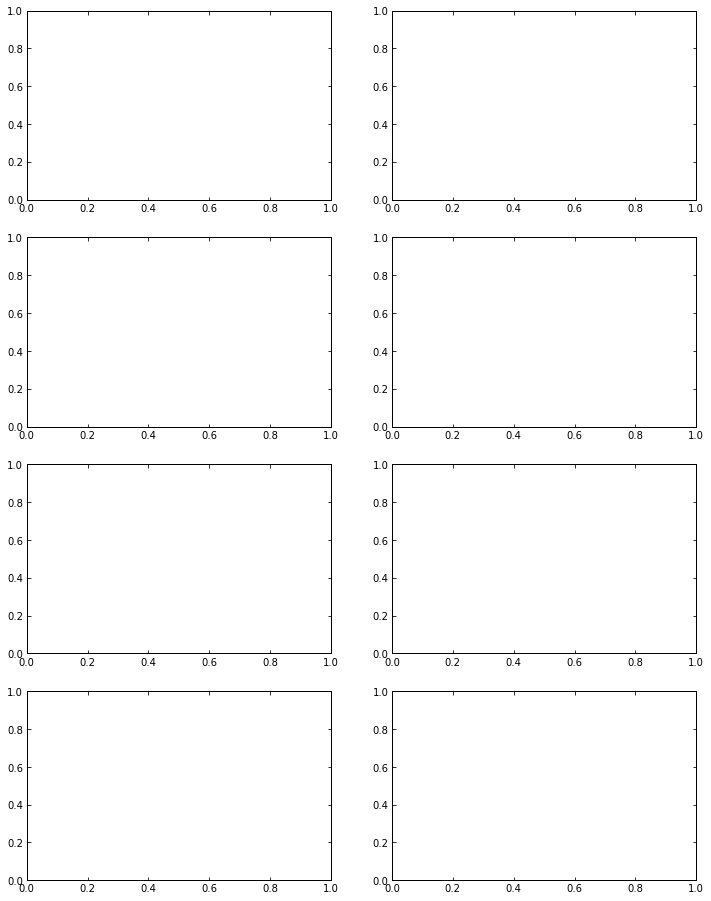

In [7]:
fig, axes = plt.subplots(4,2,figsize=(12,16))
axes[0,0].plot(times,RQ_arr[:],label='RQ')
axes[2,0].plot(times,rhon_trace[:],label='rhon trace')
axes[0,0].legend()

for i in range(0,s.N_qubits):
    axes[0,1].plot(times,qubit_x[i,:]+0.02*i,label=i)
    axes[1,0].plot(times,qubit_y[i,:]+0.02*i,label=i)
    axes[1,1].plot(times,qubit_z[i,:]+0.02*i,label=i)
    axes[2,1].plot(times,partial_traces[i,:]+0.02*i,label=i)
    axes[3,1].plot(times,partial_mat_offdiag[i,:]+0.02*i,label=i)
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[2,1].legend()
axes[0,1].set_ylim(-1.05,1.05)
axes[1,1].set_ylim(-1.05,1.05)
axes[1,0].set_ylim(-1.05,1.05)
plt.show()

In [10]:
score_history_TEST = []
RQ_history_TEST = []

num_epochs = 1
N_gates = 100
PCA_nb = 6
batch_size = 1

for jj in range(num_epochs):
    
    qb =['','','']
    clear_output(wait=False)
    print("-- number_of_epochs_trained: ", agent.number_of_epochs_trained )
    print('-- epoch=',jj, end=': ')
    RQs_at_end = []
    
    for ii in range(batch_size):
        
        print('.',end='')
    
        s.initialise_all()
        
        for kk in range( N_gates ):
        
            state = s.generate_net_input_state(PCA_nb)
            #net_input = s.generate_net_input_FULL(PCA_nb)
            action = agent.choose_action( state )
            a_type = s.get_action_type(action)
            
            reward1, reward2 = s.apply_action(action)
            
            s.time_evolve()
            s.last_action = action
            
            a_type = s.get_action_type(action)
            if a_type=='IDLE':
                for j in range(s.N_qubits):
                    qb[j]+='- '
            if a_type=='CNOT':
                qb1 = s.cnot_pairs[s.actions[action]][0]
                qb2 = s.cnot_pairs[s.actions[action]][1]
                qb[qb1]+=colored('O','blue')
                qb[qb2]+=colored('C','blue')
                for j in range(s.N_qubits):
                    if (j != qb1) and (j != qb2):
                        qb[j]+='- '
            if a_type=='BITFLIP':
                qb[ s.actions[action] ]+='F '
                for j in range(s.N_qubits):
                    if (j != s.actions[action]):
                        qb[j]+='- '
            if a_type=='ZMEASUREMENT':
                qb[s.actions[action]]+=colored('M','red')
                for j in range(s.N_qubits):
                    if (j != s.actions[action]):
                        qb[j]+='- '
            
        
        #agent.store_transition(seq_obsvs, seq_acts, seq_rwds1, seq_rwds2)
        RQs_at_end.append( s.RQ() )
        print(" ")
        print("*******************************************************")
        print("Q0: ", qb[0])
        print("Q1: ", qb[1])
        print("Q2: ", qb[2])
        print("*******************************************************")
        print(" ")
        
    RQ_history_TEST.append( np.array(RQs_at_end).mean() )




-- number_of_epochs_trained:  0
-- epoch= 0: .

ValueError: Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor(
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  7.0710677e-01
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  7.0710677e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  7.0710677e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00 -0.0000000e+00 -0.0000000e+00
   6.0084838e-17 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  7.0710677e-01  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   6.0084838e-17  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  1.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   1.0000000e+00  1.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
   0.0000000e+00  0.0000000e+00  0.0000000e+00]], shape=(1, 403), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None, 64, 403), dtype=tf.float32, name='input_1'))